In [1]:
import torch as t
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import sys

batch_size = 64
latent_dim = 60  # Dimension of the latent space
channels = 1  # Number of channels in the input data and generated images
lr = 0.00008  #0.0001
b1, b2 = 0.7, 0.999  # Beta parameters for Adam optimizer
n_epochs = 80
#n_ch = 128  # Number of channels in initial convolution layers
#sample_interval = 100  # Save a generated image every sample_interval number of batches
d_conv_channels = 4  # Number of channels in the Discriminators convlution operation
board_size = (18, 11)

drop_top_n = 4  # Exclude the problems with the top this many grades
drop_bottom_n = 1  # Exclude the problems with the bottom this many grades

In [2]:
grade_dict = {'6A': 1, '6A+': 2, '6B': 3, '6B+': 4, '6C': 5, '6C+': 6, '7A': 7, '7A+': 8,
              '7B': 9, '7B+': 10, '7C': 11, '7C+': 12, '8A': 13, '8A+': 14, '8B': 15, '8B+': 16}

# Convert grade n from ints to 1D tensors with ones in the first n positions and zeros elsewhere (one-hot encoding).
# Ex. 4 -> [1,1,1,1,0,0,0,0,0,...]
# This allows for ordinal regression in the loss function
# i.e. loss is greater for predictions further from the true grade
grade_dict_vec = {}
for grade in grade_dict:
    vec = t.zeros(len(grade_dict) - drop_bottom_n - drop_top_n)
    vec[0:grade_dict[grade]] = 1
    grade_dict_vec[grade] = vec

num_grades = len(list(grade_dict_vec.values())[0])

In [3]:
problem_path = 'problems.pkl'

class Data(Dataset):
    def __init__(self):

        with open('problems1.pkl', 'rb') as f:
            data1 = pickle.load(f)

        with open('problems2.pkl', 'rb') as f:
            data2 = pickle.load(f)

        data = {**data1, **data2}

        self.names = data.keys()
        self.grades, self.start_holds, self.mid_holds, self.end_holds, self.all_holds = [], [], [], [], []
        for name in self.names:
            problem = data[name]
            if problem[0] in grade_dict.keys():
                if grade_dict[problem[0]] in (max(grade_dict.values()) -
                                              np.array(range(drop_top_n))):
                    continue
                if grade_dict[problem[0]] in range(1, drop_bottom_n + 1):
                    continue
                self.grades.append(problem[0])
                self.start_holds.append(problem[1])
                self.mid_holds.append(problem[2])
                self.end_holds.append(problem[3])
                self.all_holds.append(problem[4])

        self.all_holds_split_channels = t.Tensor(
            [[self.start_holds[i], self.mid_holds[i], self.end_holds[i]]
             for i in range(len(self.start_holds))])

        self.start_holds = t.Tensor(self.start_holds)
        self.mid_holds = t.Tensor(self.mid_holds)
        self.end_holds = t.Tensor(self.end_holds)
        self.all_holds = t.Tensor(self.all_holds)

        self.all_holds_neg_ends = self.mid_holds - self.start_holds - self.end_holds

        self.grades_numeric = [grade_dict[grade] for grade in self.grades]
        self.grades = [grade_dict_vec[grade] for grade in self.grades]

        self.len = len(self.grades)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.all_holds[index], self.grades[index])

In [4]:
class Generator(nn.Module):
    # Takes as input a random tensor of size (batch_size, latent_dim) and sampled grades
    def __init__(self):
        super(Generator, self).__init__()

        fc1_size = 99
        fc2_size = np.prod(board_size)
        conv_channels = 16

        self.fc1 = nn.Sequential(nn.Linear(num_grades, latent_dim), nn.ReLU())

        self.lb1 = nn.Sequential(
            nn.BatchNorm1d(2*latent_dim),
            nn.Linear(2*latent_dim, fc1_size),
            nn.ReLU()
        )
        self.lb2 = nn.Sequential(
            nn.BatchNorm1d(fc1_size),
            nn.Linear(fc1_size, fc2_size),
            nn.ReLU()
        )
        self.cb1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=conv_channels,
                      kernel_size=5, padding=2),
            nn.BatchNorm2d(conv_channels),
            nn.ReLU(),
            # nn.Dropout(0.5)
        )
        self.cb2 = nn.Sequential(
            nn.Conv2d(in_channels=conv_channels,
                      out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z):
        z, grade = z
        emb = self.fc1(grade)

        # Concatenate grade and noise (z)
        gen = t.cat([z, emb], 1)

        # Run the linear blocks
        gen = self.lb1(gen)
        gen = self.lb2(gen)

        # [batch_size, 18*11] -> [batch_size, 1, 18, 11]
        gen = gen.view(-1, 1, 18, 11)

        # Run the convolutional blocks
        gen = self.cb1(gen)
        return self.cb2(gen)

In [5]:
class Discriminator(nn.Module):
    # Takes as input a data image or image generated by Generator
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=d_conv_channels, kernel_size=(
            11, 7), padding=(5, 3), stride=1)  # Convolution with 4 filters of size 11x7
        # Convolution with 1 filter of size 1 to feed info directly to next layer.  Bias set to false so that non-holds are set to zero
        self.bypass_layer = nn.Conv2d(
            in_channels=1, out_channels=1, kernel_size=1, stride=1, bias=False)

        # First fc layer with 5x18x11 neurons -> 50 neurons
        self.fc1 = nn.Sequential(
            nn.Linear((d_conv_channels + 1) * np.prod(board_size), 50), nn.Sigmoid())
        # Dropout layer to reduce overtraining
        self.dropout = nn.Dropout(p=0.5)
        self.fc_grade = nn.Sequential(
            nn.Linear(50, num_grades), nn.Sigmoid())  # Second fc layer
        self.fc_rf = nn.Sequential(nn.Linear(50, 1), nn.Sigmoid())

#         self.conv_layer = nn.Conv2d(in_channels=3, out_channels=d_conv_channels, kernel_size=(11, 7), padding=(5, 3), stride=1)  # Convolution with 4 filters of size 11x7
#         self.bypass_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, bias=False)  # Convolution with 1 filter of size 1 to feed info directly to next layer.  Bias set to false so that non-holds are set to zero

#         self.fc1 = nn.Sequential(nn.Linear((d_conv_channels + 3) * np.prod(board_size), 50), nn.Sigmoid())  # First fc layer with 5x18x11 neurons -> 50 neurons
#         self.dropout = nn.Dropout(p=0.5)  # Dropout layer to reduce overtraining
#         self.fc_grade = nn.Sequential(nn.Linear(50, num_grades), nn.Sigmoid())  # Second fc layer
#         self.fc_rf = nn.Sequential(nn.Linear(50, 1), nn.Sigmoid())

    def forward(self, problem):
        #problem = (problem[:,0] + problem[:,1] + problem[:,2]).unsqueeze(1)

        conv = self.conv_layer(problem)  # * problem
        bypass = self.bypass_layer(problem)

        conv = conv.view(conv.shape[0], -1)
        bypass = bypass.view(bypass.shape[0], -1)
        inter = t.cat((conv, bypass), 1)

        inter = self.fc1(inter)
        inter = self.dropout(inter)
        grade = self.fc_grade(inter)
        realfake = self.fc_rf(inter)
        return [grade, realfake]

In [6]:
def generate_noise(name=None, size=batch_size, std=1, mean=0):
    if name in ['rand', 'random']:
        return t.rand((size, latent_dim))
    return t.normal(mean=mean, std=std, size=(size, latent_dim))

In [7]:
if __name__ != '__main__':
    sys.exit()

In [8]:
def ordinal_regression_loss(prediction, target):
    return t.pow(nn.MSELoss(reduction='none')(prediction, target).sum(axis=1), 2).mean()

In [9]:
dataset = Data()

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss function
adversarial_loss = nn.BCELoss()

G = Generator()
D = Discriminator()

# Optimizers
optimizer_G = Adam(G.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = Adam(D.parameters(), lr=lr, betas=(b1, b2))

In [10]:
bins = np.array(range(min(dataset.grades_numeric),
                max(dataset.grades_numeric) + 2)) - 0.5
hist, _ = np.histogram(dataset.grades_numeric, bins=bins)
probabilities = hist/sum(hist)


def generate_grades(size=batch_size):
    grades = []
    for _ in range(size):
        vec = np.zeros(num_grades)
        grade = np.random.choice(np.arange(1, num_grades + 1), p=probabilities)
        vec[:grade] = 1
        grades.append(vec)
    return t.Tensor(grades)

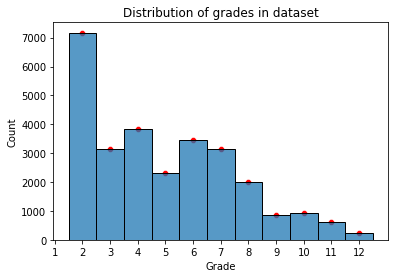

[7170 3140 3831 2307 3439 3133 2001  847  926  625  237]


<Figure size 432x288 with 0 Axes>

In [11]:
ret = sns.histplot(dataset.grades_numeric, bins=bins)
plt.xlabel('Grade')
plt.xticks(bins - 0.5)
plt.title('Distribution of grades in dataset')

hist, _ = np.histogram(dataset.grades_numeric, bins=bins)
sns.scatterplot(x=bins[:-1] + 0.5, y=hist, color='red')

# plt.yscale('log')
plt.show()
plt.clf()

print(hist)

In [12]:
loss_factor = 1
n_batches = len(dataloader)

for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):

        # --------------------
        # Train Discriminator
        # --------------------

        # Generate noise and labels to input into Generator
        noise = generate_noise()
        sampled_grades = generate_grades()

        # Run the Generator to generate problems
        gen_problems = G([noise, sampled_grades])

        # Get some real problems and their associated grades
        problems, grades = data
        problems = problems.unsqueeze(1)

        # Concatenate real problems and generated problems to run through the Discriminator
        all_problems = t.cat((problems, gen_problems.detach()))
        all_grades = t.cat((grades, sampled_grades))
        truth_values = t.Tensor([1] * len(grades) + [0]
                                * len(sampled_grades)).unsqueeze(1)

        optimizer_D.zero_grad()

        # Run the Discriminator to get its predictions
        grade_prediction, realfake = D(all_problems)

        # Compute the loss of the Discriminator
        D_loss_grade = ordinal_regression_loss(
            grade_prediction, all_grades)
        D_loss_realfake = adversarial_loss(realfake, truth_values)

        D_loss = D_loss_grade + loss_factor * D_loss_realfake

        # Train the Discriminator
        D_loss.backward()
        optimizer_D.step()

        # ---------------
        # Train Generator
        # ---------------

        # Generate noise and labels to input into Generator
        # Train with twice as much data so that G and D train on the same number of problems
        noise = generate_noise(size=2*batch_size)
        sampled_grades = generate_grades(2*batch_size)

        optimizer_G.zero_grad()

        # Generate sample problems
        gen_problems = G([noise, sampled_grades])

        # Loss measures generator's ability to fool the discriminator
        grade_prediction, realfake = D(gen_problems)
        G_loss_grade = ordinal_regression_loss(
            grade_prediction, sampled_grades)
        G_loss_realfake = adversarial_loss(
            realfake, t.ones_like(realfake))

        G_loss = G_loss_grade + loss_factor * G_loss_realfake

    #         gen_problems_binary = t.where(gen_problems > 0.5, 1, 0)
    #         num_holds = t.sum(gen_problems_binary, (2,3))
    #         unique, counts = t.unique(num_holds, return_counts=True)
    #         G_loss += counts[0].item()/10

        # Train the Generator
        G_loss.backward()
        optimizer_G.step()

        # ----------------
        # Log Progress
        # ----------------

        if (i+1) % (n_batches//8) == 0:
            print(f'Epoch: {epoch+1}/{n_epochs}  Batch: {i+1}/{n_batches}  G loss: %.3f  D loss: %.3f' %
                  (G_loss.item(), D_loss.item()))

            #gen_problems = t.round(gen_problems)
            gen_problems = t.where(gen_problems > 0.5, 1, 0)
            index = np.random.choice(len(gen_problems))
            print('Index: %d, Grade: %d\n' % (index, t.sum(
                sampled_grades[index]).item()), gen_problems[index])

KeyboardInterrupt: 

In [ ]:
t.save(G, './generator.pt')